# Detector Calibration with Volumetric Persistence

This notebook provides a user-friendly interface for detector calibration using radioactive sources and the volumetric persistence peak detection method.

## Features:
- Support for multiple data formats (Excel, CSV)
- Predefined radioactive source configurations
- Automated peak detection using volumetric persistence
- Linear calibration with cross-validation
- Comprehensive visualization and analysis tools
- Quality assessment and poor detector identification

## Workflow:
1. **Configure Sources**: Select radioactive sources and data files
2. **Process Data**: Load spectra and detect peaks
3. **Calibrate**: Perform linear calibration across all detectors
4. **Analyze**: Visualize results and identify issues
5. **Export**: Save calibration parameters and plots

## 1. Setup and Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import our calibration modules (from current directory)
from calibration_core import (
    process_source_data,
    calibrate_detector_array,
    find_poor_detectors,
    create_parameter_grid,
    print_parameter_grid,
    get_optimized_parameter_suggestions,
    create_custom_detection_params
)
from calibration_plots import (
    plot_calibration_quality_overview,
    plot_single_detector_calibration,
    plot_combined_source_spectra,
    plot_3d_energy_spectrum,
    plot_2d_energy_heatmap
)
from source_config import (
    get_source_config,
    print_source_info,
    list_available_sources
)

print("✅ Calibration modules loaded successfully!")
print("🔧 Hyperparameter configuration tools available!")
print("\n📊 Available radioactive sources:")
print_source_info()

ImportError: attempted relative import with no known parent package

## 2. Configuration

Configure your calibration setup by specifying:
- Data file path and format
- Radioactive sources to use
- Sheet names (for Excel files) or file paths (for CSV files)

In [4]:
# =============================================================================
# CONFIGURATION SECTION - MODIFY THESE SETTINGS FOR YOUR DATA
# =============================================================================

# Data file configuration
DATA_FILE_PATH = "../DATI_Gullo1.xlsx/DATI_Gullo1.xlsx"  # Path to your data file
FILE_FORMAT = "excel"  # "excel" or "csv"

# Source configuration for Excel files (sheet mapping)
# Format: {source_name: sheet_name}
EXCEL_SHEET_MAPPING = {
    "Sodium": "Sodio I",
    "Cobalt": "Cobalto I", 
    "Cesium": "Cesio I"
}

# Source configuration for CSV files (file mapping)
# Format: {source_name: file_path}
CSV_FILE_MAPPING = {
    # "Sodium": "data/sodium_spectrum.csv",
    # "Cobalt": "data/cobalt_spectrum.csv",
    # "Cesium": "data/cesium_spectrum.csv"
}

# Advanced settings
CALIBRATION_SETTINGS = {
    "cv_error_threshold": 0.05,  # Threshold for poor detector identification (MeV)
    "count_threshold": 100,      # Minimum count threshold for 3D plots
    "use_optimized_params": True, # Use optimized detection parameters per source
    "parallel_processing": True,  # Enable parallel processing for speed
}

print("⚙️ Configuration loaded:")
print(f"   Data file: {DATA_FILE_PATH}")
print(f"   Format: {FILE_FORMAT}")
if FILE_FORMAT == "excel":
    print(f"   Sources: {list(EXCEL_SHEET_MAPPING.keys())}")
else:
    print(f"   Sources: {list(CSV_FILE_MAPPING.keys())}")
print(f"   CV error threshold: {CALIBRATION_SETTINGS['cv_error_threshold']} MeV")

⚙️ Configuration loaded:
   Data file: ../DATI_Gullo1.xlsx/DATI_Gullo1.xlsx
   Format: excel
   Sources: ['Sodium', 'Cobalt', 'Cesium']
   CV error threshold: 0.05 MeV


## 2.5. Hyperparameter Configuration (Advanced)

Configure the volumetric persistence detection parameters. You can either:
- **Use optimized defaults** (recommended for most users)
- **Use energy-based optimization** (automatic parameter selection per source)
- **Create custom parameter grids** (for advanced users)

In [ ]:
# Import hyperparameter configuration functions
from calibration_core import (
    create_parameter_grid,
    print_parameter_grid,
    get_optimized_parameter_suggestions,
    create_custom_detection_params
)

# =============================================================================
# HYPERPARAMETER CONFIGURATION - CHOOSE YOUR APPROACH
# =============================================================================

# Option 1: Use automatic optimization (RECOMMENDED)
USE_AUTO_OPTIMIZATION = True  # Set to True to use automatic parameter selection per source

# Option 2: Use custom global parameters for all sources
USE_CUSTOM_GLOBAL = False     # Set to True to use the same custom parameters for all sources

# Option 3: Use source-specific custom parameters
USE_SOURCE_SPECIFIC = False   # Set to True to define custom parameters per source

# =============================================================================

if USE_AUTO_OPTIMIZATION:
    print("🤖 Using automatic parameter optimization per source")
    print("   Parameters will be optimized based on each source's energy category")
    CUSTOM_DETECTION_PARAMS = None
    
elif USE_CUSTOM_GLOBAL:
    print("⚙️  Using custom global parameters for all sources")
    
    # Define your custom parameter ranges here
    # Format: {'min': value, 'max': value, 'steps': number_of_steps}
    
    CUSTOM_DETECTION_PARAMS = create_parameter_grid(
        smoothing_config={'min': 1, 'max': 5, 'steps': 3},         # [1, 3, 5]
        bins_factor_config={'min': 1, 'max': 2, 'steps': 2},       # [1, 2]  
        threshold_config={'min': 0.01, 'max': 0.1, 'steps': 4},    # [0.01, 0.04, 0.07, 0.1]
        width_config={'min': 1, 'max': 6, 'steps': 3},             # [1, 3.5, 6]
        prominence_config={'min': 0.1, 'max': 0.5, 'steps': 3},    # [0.1, 0.3, 0.5]
        distance_config={'min': 5, 'max': 15, 'steps': 3}          # [5, 10, 15]
    )
    
    print("\n📊 Custom parameter grid:")
    print_parameter_grid(CUSTOM_DETECTION_PARAMS)
    
elif USE_SOURCE_SPECIFIC:
    print("🎯 Using source-specific custom parameters")
    
    # Define custom parameters for each source
    SOURCE_SPECIFIC_PARAMS = {
        "Sodium": create_parameter_grid(
            smoothing_config={'min': 1, 'max': 3, 'steps': 2},
            threshold_config={'min': 0.01, 'max': 0.05, 'steps': 3},
            # Add other parameters as needed...
        ),
        "Cobalt": create_parameter_grid(
            smoothing_config={'min': 3, 'max': 8, 'steps': 3},
            threshold_config={'min': 0.05, 'max': 0.2, 'steps': 3},
            # Add other parameters as needed...
        ),
        "Cesium": create_parameter_grid(
            smoothing_config={'min': 1, 'max': 5, 'steps': 3},
            threshold_config={'min': 0.01, 'max': 0.1, 'steps': 3},
            # Add other parameters as needed...
        )
    }
    
    for source, params in SOURCE_SPECIFIC_PARAMS.items():
        print(f"\n📡 {source} parameters:")
        print_parameter_grid(params)
    
    CUSTOM_DETECTION_PARAMS = SOURCE_SPECIFIC_PARAMS
    
else:
    print("🔧 Using default parameters")
    CUSTOM_DETECTION_PARAMS = None

print(f"\n✅ Hyperparameter configuration complete!")

### 📚 Parameter Guide

**Understanding Volumetric Persistence Parameters:**

- **Smoothing Range**: Window sizes for spectrum smoothing (1-10)
  - *Lower values*: Preserve peak details, detect narrow peaks
  - *Higher values*: Reduce noise, merge close peaks

- **Bins Factor Range**: Channel aggregation factors (1-3)  
  - *1*: Full resolution
  - *2-3*: Reduced resolution, faster processing

- **Threshold Range**: Minimum peak height thresholds (0.01-0.5)
  - *Lower values*: Detect weaker peaks
  - *Higher values*: Only strong peaks

- **Width Range**: Expected peak width in channels (1-10)
  - *Adjust based on your detector resolution*

- **Prominence Range**: Peak prominence requirements (0.05-1.0)
  - *Lower values*: Accept smaller peaks above background
  - *Higher values*: Require distinct peaks

- **Distance Range**: Minimum separation between peaks (3-30)
  - *Lower values*: Allow closer peaks
  - *Higher values*: Enforce peak separation

**💡 Tips:**
- Start with auto-optimization for your first calibration
- For fine-tuning, adjust 2-3 parameters at a time
- More parameter combinations = better detection but slower processing
- Use source-specific parameters if sources have very different characteristics

In [ ]:
# =============================================================================
# PARAMETER EXPLORATION (OPTIONAL) - Test different parameter ranges
# =============================================================================

EXPLORE_PARAMETERS = False  # Set to True to explore parameter effects

if EXPLORE_PARAMETERS:
    print("🔍 Parameter Exploration Mode")
    print("=" * 40)
    
    # Show optimization suggestions for different energy categories
    categories = ['low_energy', 'medium_energy', 'high_energy', 'multi_peak']
    
    for category in categories:
        print(f"\n📊 {category.replace('_', ' ').title()} Suggestions:")
        suggestions = get_optimized_parameter_suggestions(category)
        
        # Create and display the parameter grid
        test_params = create_parameter_grid(**{f"{k}_config": v for k, v in suggestions.items()})
        print_parameter_grid(test_params)
        print()
    
    # Example: Test parameter impact on a specific source
    print("🧪 Example: Testing parameter variations for Cesium")
    
    # Conservative parameters (fewer, more restrictive)
    conservative_params = create_parameter_grid(
        smoothing_config={'min': 1, 'max': 3, 'steps': 2},     # Less smoothing variety
        threshold_config={'min': 0.05, 'max': 0.1, 'steps': 2}, # Higher thresholds
        prominence_config={'min': 0.3, 'max': 0.5, 'steps': 2}  # Higher prominence
    )
    
    # Aggressive parameters (more, more permissive)  
    aggressive_params = create_parameter_grid(
        smoothing_config={'min': 1, 'max': 7, 'steps': 4},     # More smoothing variety
        threshold_config={'min': 0.01, 'max': 0.1, 'steps': 5}, # Lower minimum threshold
        prominence_config={'min': 0.1, 'max': 0.5, 'steps': 4}  # Lower minimum prominence
    )
    
    print("\n🛡️  Conservative approach (fewer, stronger peaks):")
    print_parameter_grid(conservative_params)
    
    print("\n🚀 Aggressive approach (more, weaker peaks):")
    print_parameter_grid(aggressive_params)
    
    print("\n💡 Choose conservative for clean spectra, aggressive for noisy/complex spectra")

else:
    print("⏭️  Parameter exploration skipped (set EXPLORE_PARAMETERS=True to enable)")

### 🚀 Quick Examples

Here are some common hyperparameter configuration patterns:

In [ ]:
# Quick examples of hyperparameter configuration (for reference)
SHOW_EXAMPLES = False  # Set to True to run examples

if SHOW_EXAMPLES:
    print("📖 Hyperparameter Configuration Examples")
    print("=" * 50)
    
    # Example 1: Simple parameter grid with minimal settings
    print("\n1️⃣ Minimal custom grid (fast processing):")
    minimal_params = create_parameter_grid(
        smoothing_config={'min': 1, 'max': 3, 'steps': 2},      # Just 2 smoothing values
        threshold_config={'min': 0.05, 'max': 0.1, 'steps': 2}  # Just 2 threshold values
    )
    print_parameter_grid(minimal_params)
    
    # Example 2: High-resolution grid (thorough but slow)
    print("\n2️⃣ High-resolution grid (thorough detection):")
    detailed_params = create_parameter_grid(
        smoothing_config={'min': 1, 'max': 8, 'steps': 5},
        threshold_config={'min': 0.01, 'max': 0.2, 'steps': 6},
        prominence_config={'min': 0.05, 'max': 0.8, 'steps': 5}
    )
    print_parameter_grid(detailed_params)
    
    # Example 3: Using source-based optimization
    print("\n3️⃣ Source-based parameter creation:")
    cesium_params = create_custom_detection_params(source_name="Cesium")
    cobalt_params = create_custom_detection_params(source_name="Cobalt")
    
    print("Cesium (medium energy) parameters:")
    print_parameter_grid(cesium_params)
    
    print("\nCobalt (high energy) parameters:")  
    print_parameter_grid(cobalt_params)
    
    # Example 4: Custom modification of optimized parameters
    print("\n4️⃣ Custom modification of auto-optimized parameters:")
    modified_params = create_custom_detection_params(
        source_name="Cesium",  # Start with Cesium optimization
        threshold_config={'min': 0.001, 'max': 0.05, 'steps': 8},  # Override threshold only
        smoothing_config={'min': 1, 'max': 10, 'steps': 6}         # Override smoothing only
    )
    print_parameter_grid(modified_params)

else:
    print("📖 Examples available (set SHOW_EXAMPLES=True to view)")

## 3. Data Processing

Load spectral data and detect peaks using volumetric persistence for all configured sources.

In [5]:
# Process each source and collect data
sources_data = {}
expected_energies = {}

# Determine which mapping to use based on file format
source_mapping = EXCEL_SHEET_MAPPING if FILE_FORMAT == "excel" else CSV_FILE_MAPPING

print("🔄 Processing sources...")
print("=" * 50)

for source_name in source_mapping.keys():
    print(f"\n📡 Processing {source_name}...")
    
    # Get source configuration
    source_config = get_source_config(source_name)
    expected_energies[source_name] = source_config['energies']
    
    # Configure detection parameters based on user choice
    if USE_AUTO_OPTIMIZATION:
        # Use optimized parameters for this source's energy category
        detection_params = source_config['detection_params'].copy()
        print(f"   🤖 Using auto-optimized parameters for {source_config['energy_category']}")
    elif USE_CUSTOM_GLOBAL and CUSTOM_DETECTION_PARAMS:
        # Use global custom parameters
        detection_params = CUSTOM_DETECTION_PARAMS.copy()
        print(f"   ⚙️ Using custom global parameters")
    elif USE_SOURCE_SPECIFIC and CUSTOM_DETECTION_PARAMS:
        # Use source-specific parameters
        detection_params = CUSTOM_DETECTION_PARAMS.get(source_name, source_config['detection_params']).copy()
        print(f"   🎯 Using source-specific custom parameters")
    else:
        # Fallback to default source parameters
        detection_params = source_config['detection_params'].copy()
        print(f"   🔧 Using default parameters")
    
    # Apply global settings
    detection_params['parallel'] = CALIBRATION_SETTINGS['parallel_processing']
    
    # Prepare source configuration for processing
    if FILE_FORMAT == "excel":
        processing_config = {
            'sheet_name': source_mapping[source_name],
            'top_k': source_config['top_k']
        }
    else:
        processing_config = {
            'file_path': source_mapping[source_name],
            'top_k': source_config['top_k']
        }
    
    try:
        # Process the source data
        if FILE_FORMAT == "excel":
            spectra, peaks = process_source_data(
                DATA_FILE_PATH, processing_config, detection_params
            )
        else:
            spectra, peaks = process_source_data(
                source_mapping[source_name], processing_config, detection_params
            )
        
        sources_data[source_name] = {
            'spectra': spectra,
            'peaks': peaks,
            'config': source_config,
            'detection_params': detection_params  # Store the actual parameters used
        }
        
        n_channels, n_detectors = spectra.shape
        total_peaks = sum(len(detector_peaks) for detector_peaks in peaks.values())
        
        print(f"   ✅ Success: {n_channels} channels, {n_detectors} detectors")
        print(f"   🎯 Total peaks detected: {total_peaks}")
        print(f"   🔍 Expected energies: {source_config['energies']} MeV")
        
        # Show parameter summary for this source
        key_params = ['smoothing_range', 'threshold_range', 'prominence_range']
        param_summary = {k: detection_params[k] for k in key_params if k in detection_params}
        print(f"   📊 Key parameters used: {param_summary}")
        
    except Exception as e:
        print(f"   ❌ Error processing {source_name}: {str(e)}")
        continue

print(f"\n✅ Data processing complete!")
print(f"   Sources processed: {len(sources_data)}")
if sources_data:
    first_source = next(iter(sources_data.values()))
    n_detectors = first_source['spectra'].shape[1]
    print(f"   Total detectors: {n_detectors}")
    
    # Show overall parameter summary
    print(f"\n📋 Parameter Summary by Source:")
    for source_name, data in sources_data.items():
        params = data['detection_params']
        total_combinations = 1
        for key in ['smoothing_range', 'bins_factor_range', 'threshold_range', 
                   'width_range', 'prominence_range', 'distance_range']:
            if key in params:
                total_combinations *= len(params[key])
        print(f"   {source_name}: {total_combinations:,} parameter combinations tested")

🔄 Processing sources...

📡 Processing Sodium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 256
   🔍 Expected energies: [0.511] MeV

📡 Processing Cobalt...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 256
   🔍 Expected energies: [0.511] MeV

📡 Processing Cobalt...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 640
   🔍 Expected energies: [1.17, 1.33] MeV

📡 Processing Cesium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 640
   🔍 Expected energies: [1.17, 1.33] MeV

📡 Processing Cesium...
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 256
   🔍 Expected energies: [0.662] MeV

✅ Data processing complete!
   Sources processed: 3
   Total detectors: 128
   ✅ Success: 2047 channels, 128 detectors
   🎯 Total peaks detected: 256
   🔍 Expected energies: [0.662] MeV

✅ Data processing complete!
   Sources processed: 3
   Total detectors: 128


## 4. Detector Calibration

Perform linear calibration using detected peaks and known energies from all sources.

In [6]:
# Perform calibration across all detectors
print("🎯 Performing detector calibration...")
print("=" * 50)

try:
    calibration_results = calibrate_detector_array(sources_data, expected_energies)
    
    # Calculate calibration statistics
    successful_calibrations = 0
    cv_errors = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        if calib['slope'] is not None:
            successful_calibrations += 1
            if calib['cv_error'] is not None:
                cv_errors.append(calib['cv_error'])
    
    print(f"✅ Calibration complete!")
    print(f"   Detectors calibrated: {successful_calibrations}/{len(calibration_results)}")
    
    if cv_errors:
        mean_cv_error = np.mean(cv_errors)
        std_cv_error = np.std(cv_errors)
        print(f"   Average CV error: {mean_cv_error:.4f} ± {std_cv_error:.4f} MeV")
        print(f"   CV error range: {min(cv_errors):.4f} - {max(cv_errors):.4f} MeV")
    
    # Identify poor detectors
    poor_detectors = find_poor_detectors(
        calibration_results, 
        CALIBRATION_SETTINGS['cv_error_threshold']
    )
    
    print(f"\n🚨 Poor detectors (CV error > {CALIBRATION_SETTINGS['cv_error_threshold']} MeV):")
    if poor_detectors:
        print(f"   Detectors: {poor_detectors}")
        print(f"   Count: {len(poor_detectors)}/{len(calibration_results)} ({100*len(poor_detectors)/len(calibration_results):.1f}%)")
    else:
        print(f"   None! All detectors meet quality threshold.")
    
except Exception as e:
    print(f"❌ Calibration failed: {str(e)}")
    calibration_results = {}
    poor_detectors = []

🎯 Performing detector calibration...
✅ Calibration complete!
   Detectors calibrated: 128/128
   Average CV error: 1.0880 ± 0.9587 MeV
   CV error range: 0.0701 - 4.4890 MeV

🚨 Poor detectors (CV error > 0.05 MeV):
   Detectors: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
   Count: 128/128 (100.0%)


## 5. Calibration Quality Analysis

Visualize calibration quality across all detectors with comprehensive plots.

📊 Generating calibration quality overview...


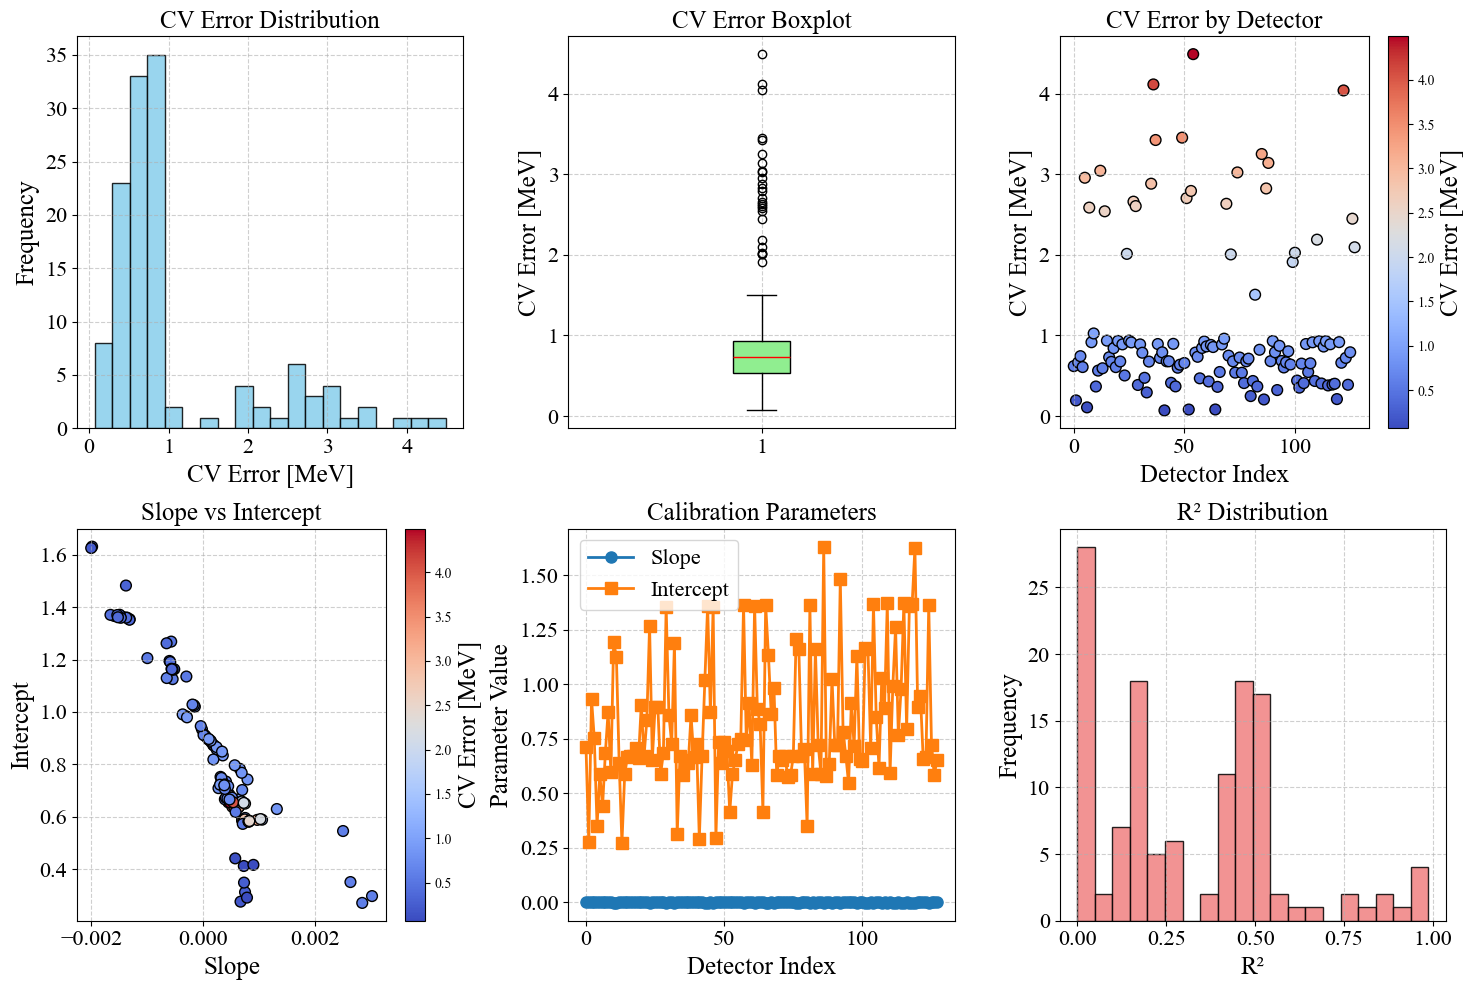

In [7]:
if calibration_results:
    print("📊 Generating calibration quality overview...")
    plot_calibration_quality_overview(calibration_results)
else:
    print("❌ No calibration results to plot.")

## 6. Individual Detector Analysis

Examine calibration details for specific detectors.

🔍 Detailed analysis of sample detectors...

🔬 Detector 0:
   Slope: 0.000357 MeV/channel
   Intercept: 0.711894 MeV
   CV Error: 0.619358 MeV
   R²: 0.230292
   Calibration points: 4


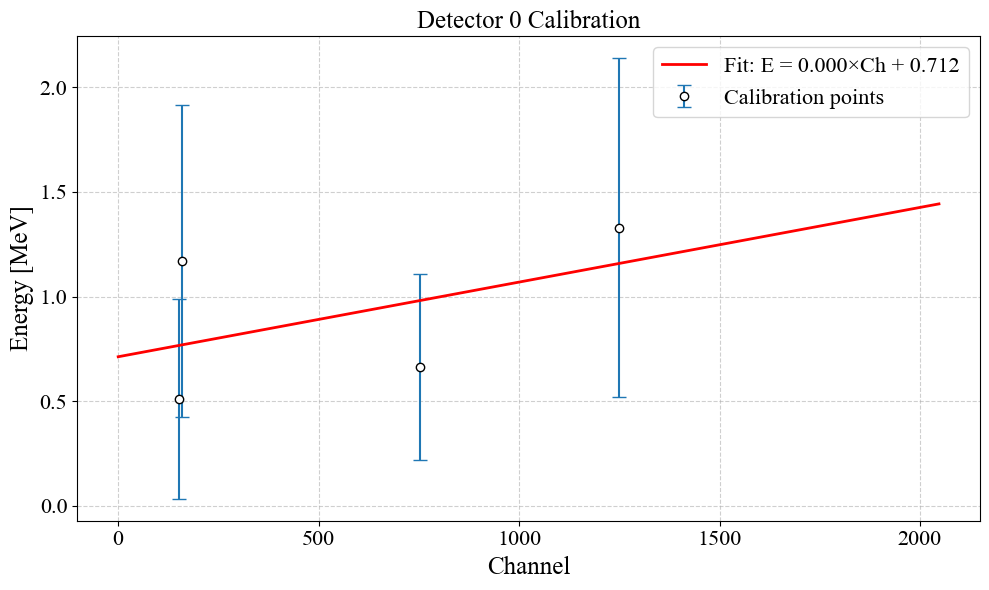

Detector 0 average LOOCV error: 0.6194 MeV

🔬 Detector 1:
   Slope: 0.000672 MeV/channel
   Intercept: 0.276305 MeV
   CV Error: 0.194034 MeV
   R²: 0.926828
   Calibration points: 4


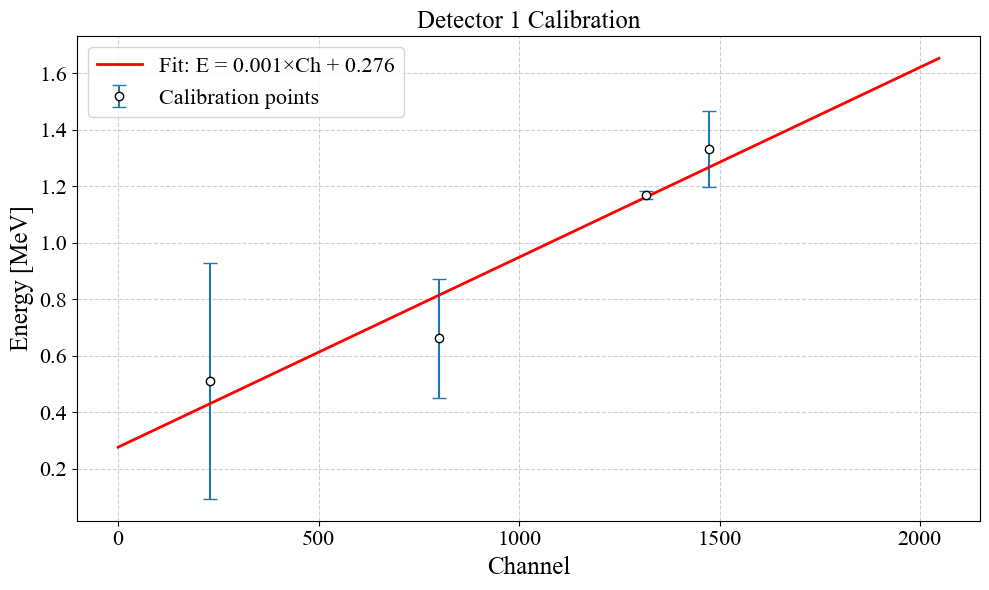

Detector 1 average LOOCV error: 0.1940 MeV

🔬 Detector 2:
   Slope: -0.000019 MeV/channel
   Intercept: 0.933672 MeV
   CV Error: 0.665554 MeV
   R²: 0.000920
   Calibration points: 4


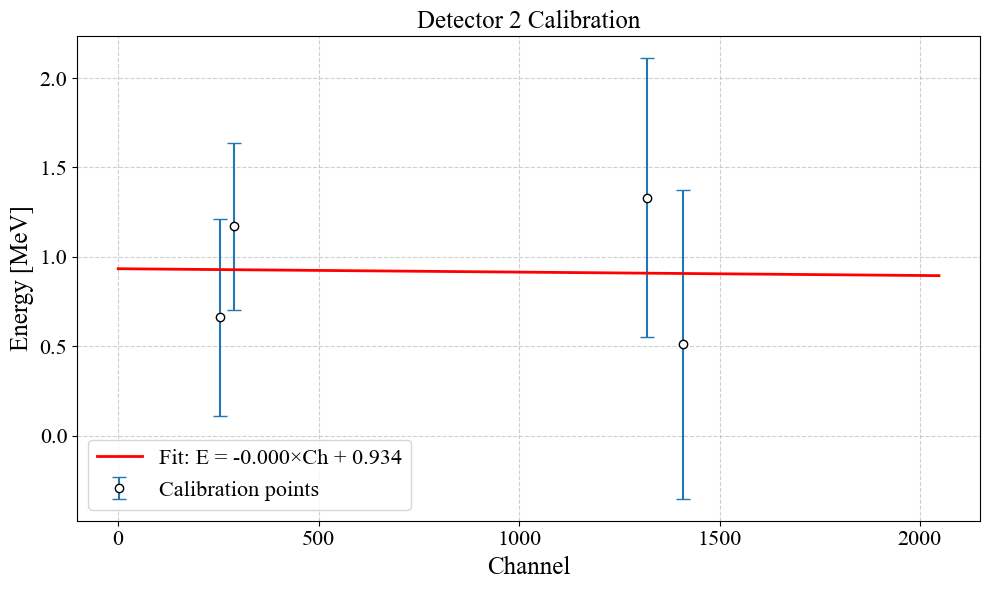

Detector 2 average LOOCV error: 0.6656 MeV


In [8]:
# Analyze a few sample detectors
sample_detectors = [0, 1, 2]  # Change these indices as needed

if calibration_results:
    print("🔍 Detailed analysis of sample detectors...")
    print("=" * 50)
    
    for detector_idx in sample_detectors:
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            print(f"\n🔬 Detector {detector_idx}:")
            if calib['slope'] is not None:
                print(f"   Slope: {calib['slope']:.6f} MeV/channel")
                print(f"   Intercept: {calib['intercept']:.6f} MeV")
                print(f"   CV Error: {calib['cv_error']:.6f} MeV")
                print(f"   R²: {calib['r_squared']:.6f}")
                print(f"   Calibration points: {calib['n_points']}")
                
                # Plot individual calibration
                plot_single_detector_calibration(detector_idx, result)
            else:
                print(f"   ❌ Calibration failed (insufficient data points)")
        else:
            print(f"\n❌ Detector {detector_idx} not found in results")
else:
    print("❌ No calibration results available for analysis.")

## 7. Source Spectrum Visualization

Visualize combined spectra from all sources for sample detectors.

📈 Combined spectra visualization for detector 0...


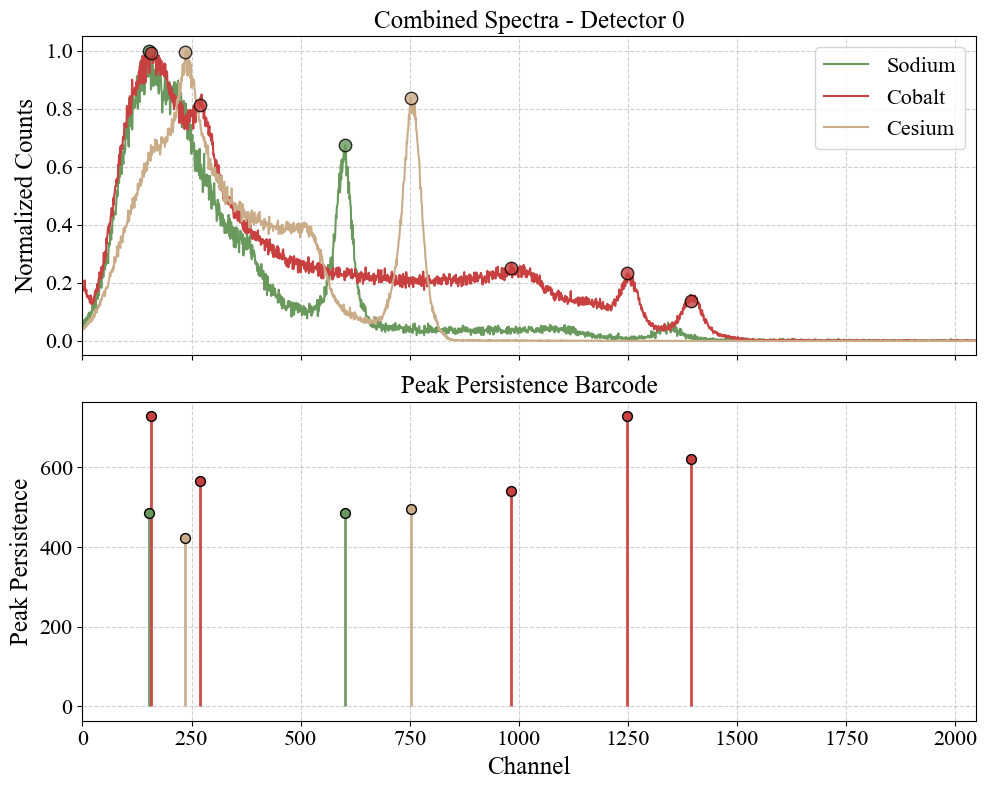

In [9]:
# Plot combined spectra for sample detectors
sample_detector_for_spectra = 0  # Change this as needed

if sources_data:
    print(f"📈 Combined spectra visualization for detector {sample_detector_for_spectra}...")
    
    # Custom colors for sources
    source_colors = {
        "Cesium": "#CBAC88", 
        "Sodium": "#69995D", 
        "Cobalt": "#C94040"
    }
    
    plot_combined_source_spectra(
        sample_detector_for_spectra, 
        sources_data, 
        source_colors
    )
else:
    print("❌ No source data available for spectrum visualization.")

## 8. Energy Space Visualization

Create 3D and 2D visualizations of spectra in calibrated energy space.

🌐 3D energy space visualization for Cobalt...


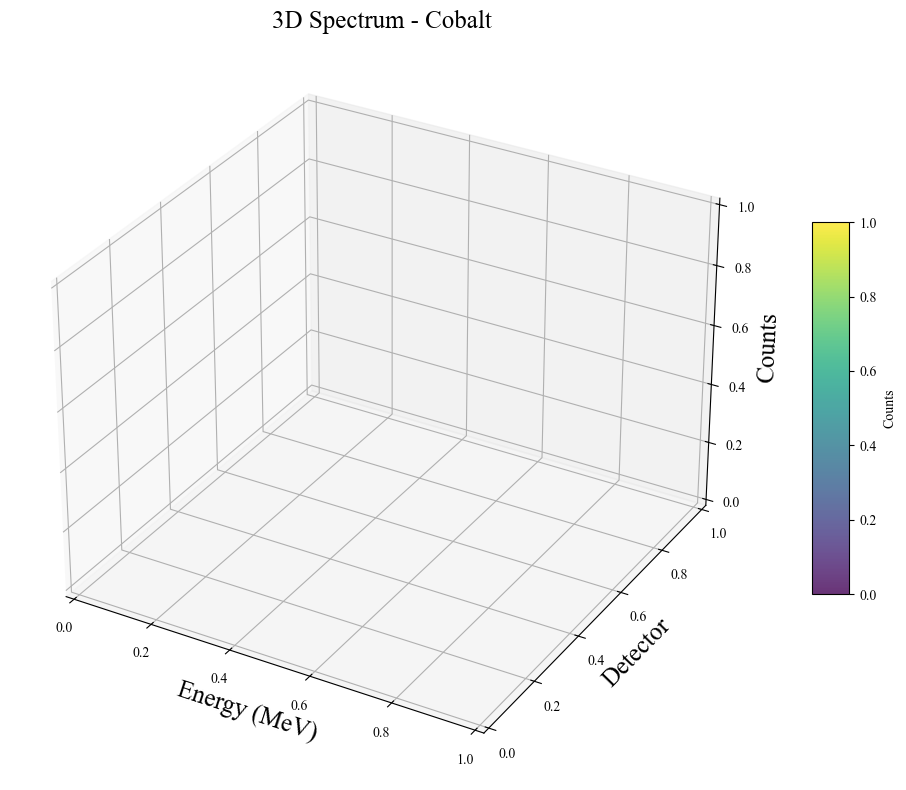

In [10]:
# 3D Energy space visualization
if sources_data and calibration_results:
    # Choose a source for visualization
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🌐 3D energy space visualization for {visualization_source}...")
        
        plot_3d_energy_spectrum(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            CALIBRATION_SETTINGS['count_threshold']
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
        print(f"   Available sources: {list(sources_data.keys())}")
else:
    print("❌ Insufficient data for 3D visualization.")

🗺️ 2D energy heatmap for Cobalt...


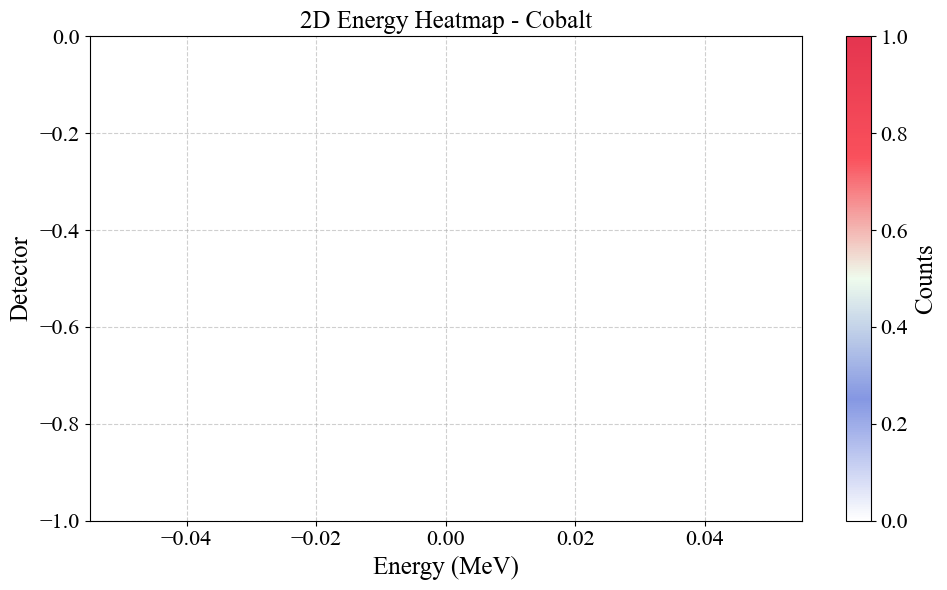

In [11]:
# 2D Energy heatmap visualization
if sources_data and calibration_results:
    visualization_source = "Cobalt"  # Change this to any available source
    
    if visualization_source in sources_data:
        print(f"🗺️ 2D energy heatmap for {visualization_source}...")
        
        plot_2d_energy_heatmap(
            sources_data,
            calibration_results,
            visualization_source,
            poor_detectors,
            CALIBRATION_SETTINGS['count_threshold']
        )
    else:
        print(f"❌ Source '{visualization_source}' not available for visualization.")
else:
    print("❌ Insufficient data for 2D heatmap visualization.")

## 9. Poor Detector Investigation

Investigate detectors with poor calibration performance in detail.

🚨 Investigating 128 poor detector(s)...

🔍 Detector 0 Analysis:
   CV Error: 0.619358 MeV
   R²: 0.230292
   Data points: 4
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cobalt: 2/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


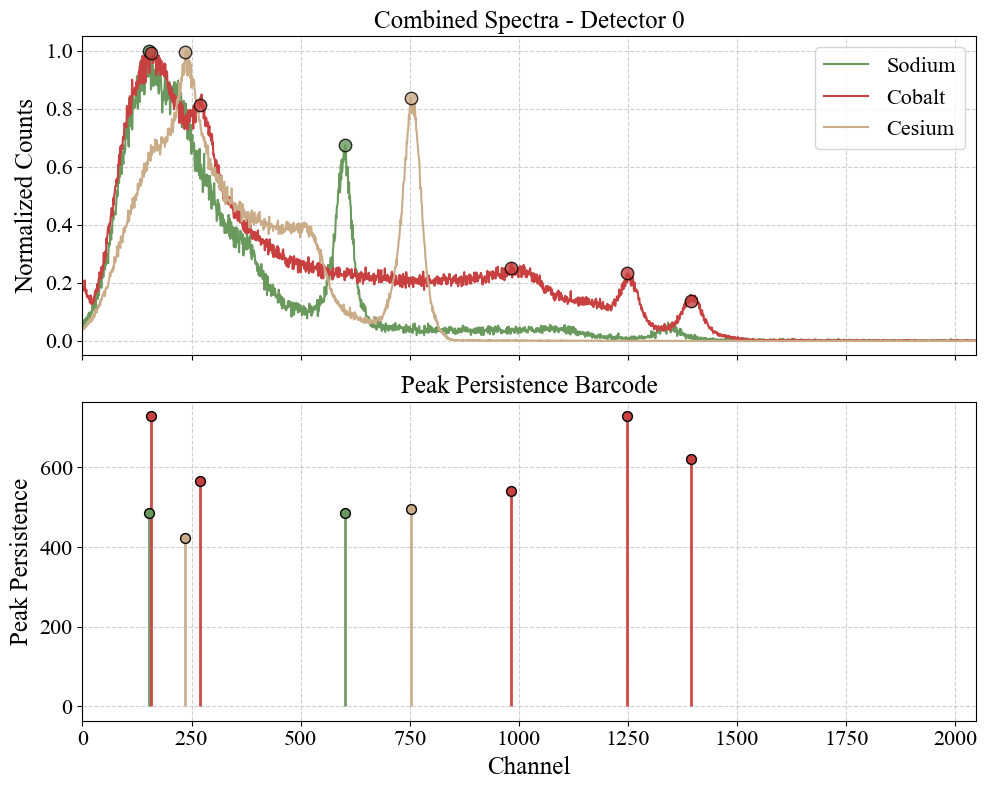

   📈 Calibration curve:


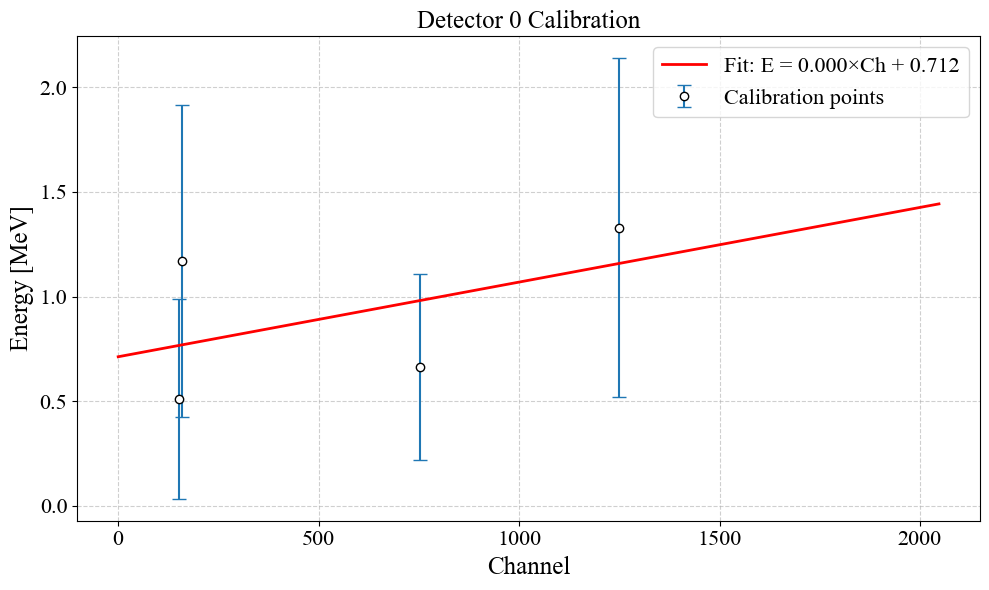

Detector 0 average LOOCV error: 0.6194 MeV

----------------------------------------

🔍 Detector 1 Analysis:
   CV Error: 0.194034 MeV
   R²: 0.926828
   Data points: 4
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cobalt: 2/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


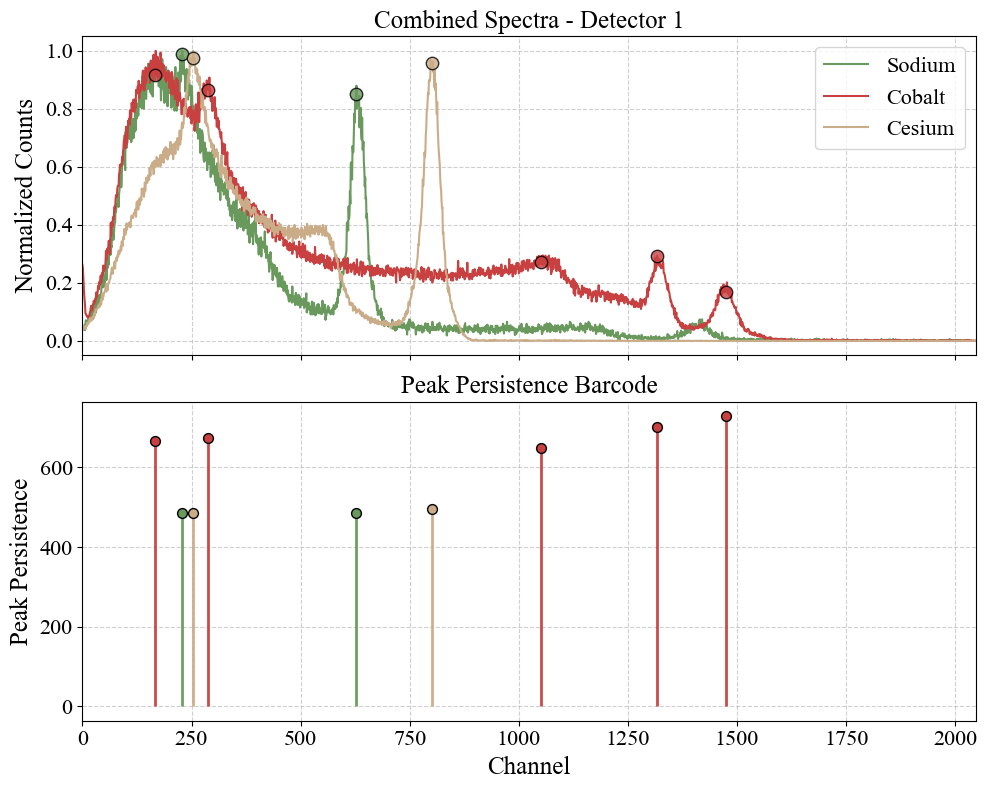

   📈 Calibration curve:


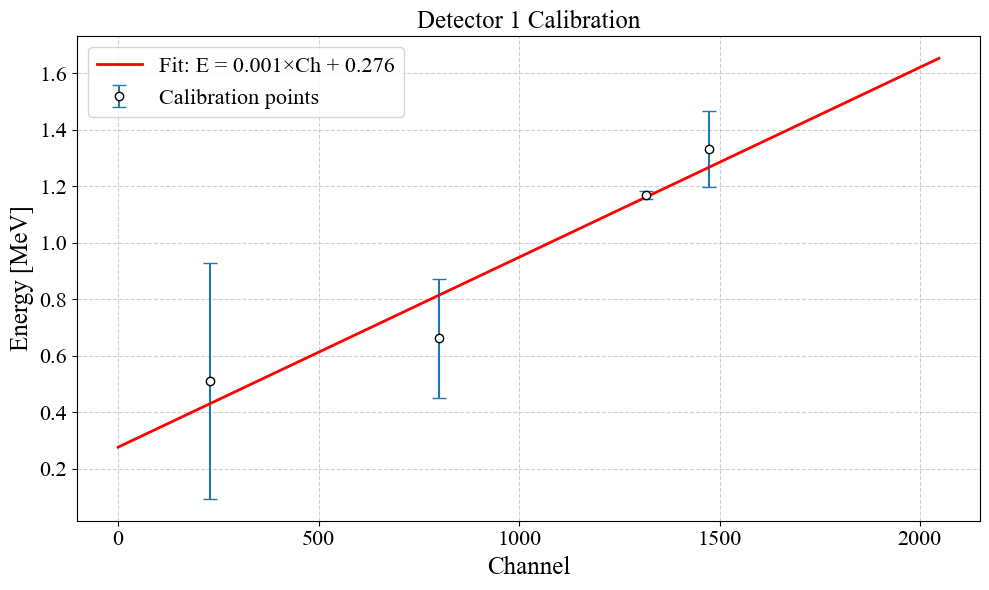

Detector 1 average LOOCV error: 0.1940 MeV

----------------------------------------

🔍 Detector 2 Analysis:
   CV Error: 0.665554 MeV
   R²: 0.000920
   Data points: 4
   Peaks detected per source:
     Sodium: 1/1 peaks
     Cobalt: 2/2 peaks
     Cesium: 1/1 peaks
   📊 Spectrum visualization:


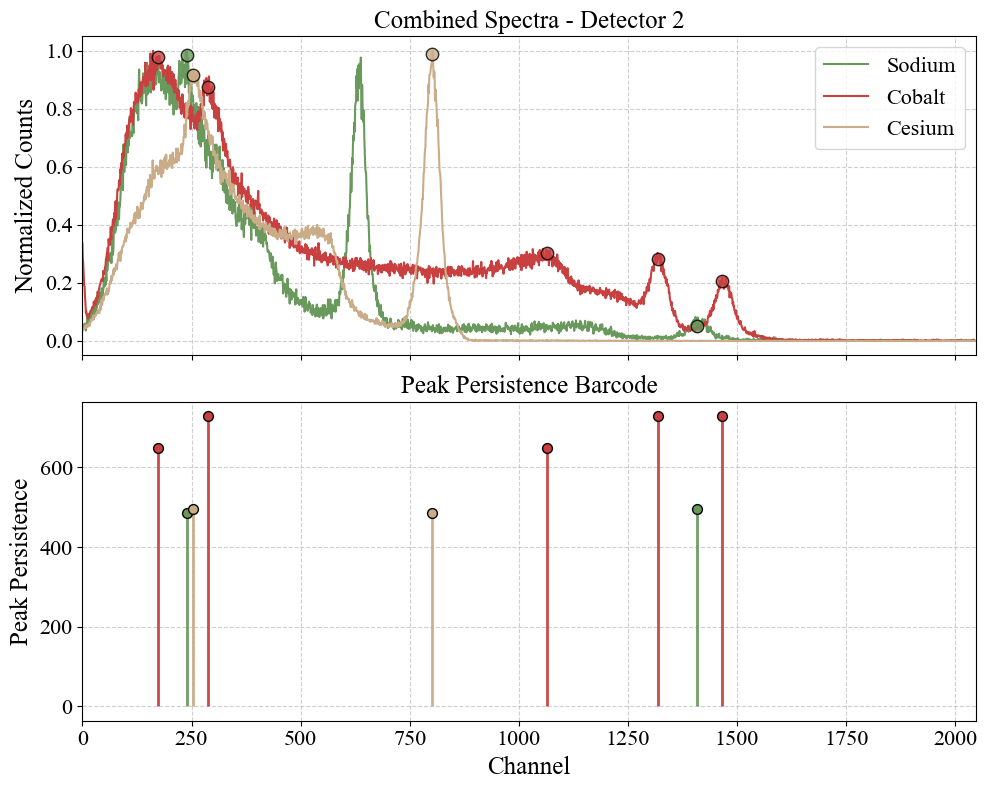

   📈 Calibration curve:


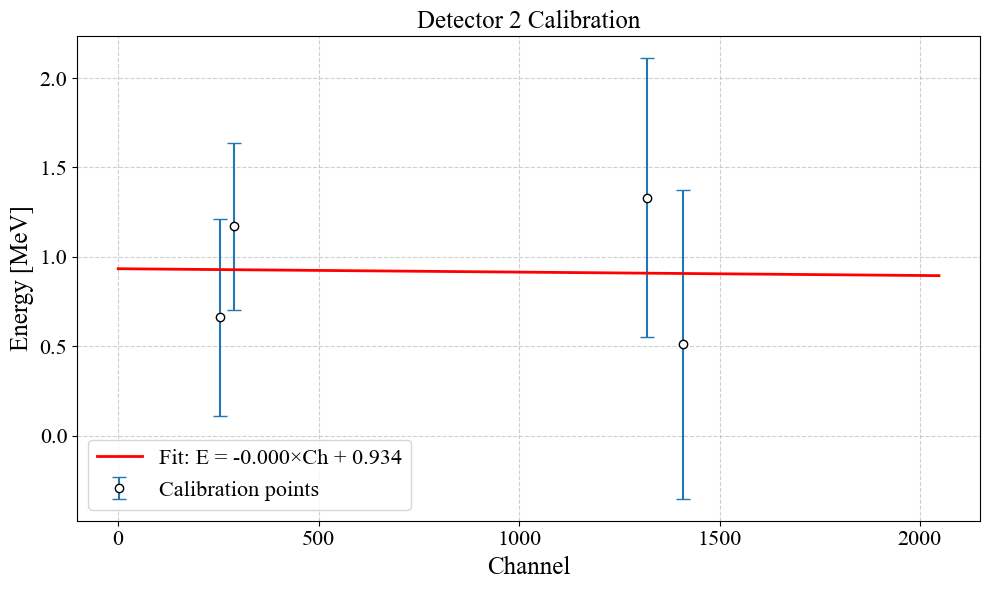

Detector 2 average LOOCV error: 0.6656 MeV

----------------------------------------


In [12]:
# Investigate poor detectors
if poor_detectors:
    print(f"🚨 Investigating {len(poor_detectors)} poor detector(s)...")
    print("=" * 60)
    
    for detector_idx in poor_detectors[:3]:  # Limit to first 3 for notebook clarity
        print(f"\n🔍 Detector {detector_idx} Analysis:")
        
        if detector_idx in calibration_results:
            result = calibration_results[detector_idx]
            calib = result['calibration']
            
            print(f"   CV Error: {calib['cv_error']:.6f} MeV")
            print(f"   R²: {calib['r_squared']:.6f}")
            print(f"   Data points: {calib['n_points']}")
            
            # Show peaks detected per source
            peaks_per_source = result['peaks_per_source']
            print(f"   Peaks detected per source:")
            for source, peaks in peaks_per_source.items():
                expected = len(expected_energies[source])
                detected = len(peaks)
                print(f"     {source}: {detected}/{expected} peaks")
            
            # Plot spectra for this detector
            print(f"   📊 Spectrum visualization:")
            plot_combined_source_spectra(detector_idx, sources_data)
            
            # Plot calibration if enough points
            if calib['slope'] is not None:
                print(f"   📈 Calibration curve:")
                plot_single_detector_calibration(detector_idx, result)
        
        print("\n" + "-" * 40)
else:
    print("✅ No poor detectors found - all detectors meet quality criteria!")

## 10. Export Calibration Results

Save calibration parameters and summary statistics for future use.

In [13]:
# Export calibration results
if calibration_results:
    print("💾 Exporting calibration results...")
    
    # Create calibration summary DataFrame
    export_data = []
    
    for detector_idx, result in calibration_results.items():
        calib = result['calibration']
        export_data.append({
            'detector_index': detector_idx,
            'slope_MeV_per_channel': calib['slope'],
            'intercept_MeV': calib['intercept'],
            'cv_error_MeV': calib['cv_error'],
            'r_squared': calib['r_squared'],
            'n_calibration_points': calib['n_points'],
            'p_value': calib['p_value'],
            'std_error': calib['std_err'],
            'quality_flag': 'good' if detector_idx not in poor_detectors else 'poor'
        })
    
    calibration_df = pd.DataFrame(export_data)
    
    # Save to CSV
    output_file = "detector_calibration_results.csv"
    calibration_df.to_csv(output_file, index=False)
    
    print(f"✅ Calibration results saved to: {output_file}")
    
    # Display summary statistics
    print("\n📋 Calibration Summary:")
    print("=" * 50)
    
    successful_calibrations = calibration_df['slope_MeV_per_channel'].notna().sum()
    good_detectors = (calibration_df['quality_flag'] == 'good').sum()
    
    print(f"Total detectors: {len(calibration_df)}")
    print(f"Successful calibrations: {successful_calibrations}")
    print(f"Good quality detectors: {good_detectors}")
    print(f"Poor quality detectors: {len(poor_detectors)}")
    
    if successful_calibrations > 0:
        valid_df = calibration_df.dropna(subset=['cv_error_MeV'])
        if len(valid_df) > 0:
            print(f"\nCV Error Statistics:")
            print(f"  Mean: {valid_df['cv_error_MeV'].mean():.6f} MeV")
            print(f"  Std:  {valid_df['cv_error_MeV'].std():.6f} MeV")
            print(f"  Min:  {valid_df['cv_error_MeV'].min():.6f} MeV")
            print(f"  Max:  {valid_df['cv_error_MeV'].max():.6f} MeV")
        
        valid_r2 = calibration_df.dropna(subset=['r_squared'])
        if len(valid_r2) > 0:
            print(f"\nR² Statistics:")
            print(f"  Mean: {valid_r2['r_squared'].mean():.6f}")
            print(f"  Min:  {valid_r2['r_squared'].min():.6f}")
            print(f"  Max:  {valid_r2['r_squared'].max():.6f}")
    
    # Display first few rows
    print(f"\n🔢 Sample calibration data:")
    display(calibration_df.head(10))
    
else:
    print("❌ No calibration results to export.")

💾 Exporting calibration results...
✅ Calibration results saved to: detector_calibration_results.csv

📋 Calibration Summary:
Total detectors: 128
Successful calibrations: 128
Good quality detectors: 0
Poor quality detectors: 128

CV Error Statistics:
  Mean: 1.088016 MeV
  Std:  0.962444 MeV
  Min:  0.070084 MeV
  Max:  4.488990 MeV

R² Statistics:
  Mean: 0.321252
  Min:  0.000005
  Max:  0.986855

🔢 Sample calibration data:


,detector_index,slope_MeV_per_channel,intercept_MeV,cv_error_MeV,r_squared,n_calibration_points,p_value,std_error,quality_flag
0,0,0.000357,0.711894,0.619358,0.230292,4,0.520112,0.000462,poor
1,1,0.000672,0.276305,0.194034,0.926828,4,0.037281,0.000134,poor
2,2,-0.000019,0.933672,0.665554,0.000920,4,0.969668,0.000440,poor
3,3,0.000314,0.752249,0.742907,0.106149,4,0.674194,0.000644,poor
4,4,0.002641,0.351059,0.607883,0.179320,4,0.576538,0.003995,poor
5,5,0.000702,0.586686,2.956095,0.535110,4,0.268488,0.000462,poor
6,6,0.000577,0.441296,0.107678,0.972730,4,0.013729,0.000068,poor
7,7,0.000458,0.684610,2.585722,0.430124,4,0.344161,0.000373,poor
8,8,0.000182,0.873359,0.915967,0.000579,4,0.975930,0.005348,poor
9,9,0.000755,0.595676,1.024589,0.592763,4,0.230089,0.000443,poor


## 11. Summary and Recommendations

Final summary of the calibration process and recommendations for next steps.

In [15]:
print("📊 CALIBRATION SUMMARY")
print("=" * 60)

if sources_data:
    print(f"\n✅ Sources processed: {len(sources_data)}")
    for source_name, data in sources_data.items():
        n_channels, n_detectors = data['spectra'].shape
        print(f"   {source_name}: {n_channels} channels, {n_detectors} detectors")
    
    if calibration_results:
        successful = sum(1 for r in calibration_results.values() 
                        if r['calibration']['slope'] is not None)
        print(f"\n🎯 Calibration success rate: {successful}/{len(calibration_results)} "
              f"({100*successful/len(calibration_results):.1f}%)")
        
        if poor_detectors:
            print(f"\n⚠️  Poor detectors: {len(poor_detectors)} "
                  f"({100*len(poor_detectors)/len(calibration_results):.1f}%)")
            print(f"   Detector indices: {poor_detectors[:10]}"  # Show first 10
            if len(poor_detectors) > 10:
                print(f"   ... and {len(poor_detectors)-10} more")
        else:
            print(f"\n✅ All detectors meet quality threshold!")
        
        print(f"\n📁 Output files generated:")
        print(f"   📄 detector_calibration_results.csv")
        print(f"   📊 Various calibration plots (displayed above)")
        
        print(f"\n🔍 Recommendations:")
        if poor_detectors:
            print(f"   🔧 Investigate poor detectors for hardware issues")
            print(f"   📊 Consider excluding poor detectors from analysis")
            print(f"   ⚙️  Try adjusting detection parameters for poor detectors")
        
        cv_errors = [r['calibration']['cv_error'] for r in calibration_results.values()
                    if r['calibration']['cv_error'] is not None]
        if cv_errors:
            mean_error = np.mean(cv_errors)
            if mean_error > 0.02:
                print(f"   📈 Consider using more calibration sources for better accuracy")
            if mean_error < 0.01:
                print(f"   ✨ Excellent calibration accuracy achieved!")
        
        print(f"\n🚀 Next steps:")
        print(f"   📊 Use calibration parameters for energy analysis")
        print(f"   🔄 Repeat calibration periodically to check stability")
        print(f"   📋 Document calibration procedure and results")
    else:
        print(f"\n❌ Calibration failed - check data and parameters")
else:
    print(f"\n❌ No data processed - check file paths and configuration")

print(f"\n" + "=" * 60)
print(f"🎉 Calibration analysis complete!"))

SyntaxError: invalid syntax (2750804105.py, line 20)